In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Islam Salahuddin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Islam
[nltk_data]     Salahuddin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Islam
[nltk_data]     Salahuddin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Islam
[nltk_data]     Salahuddin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data importing, exploration, lemmatization and initial preparation

Link to the dataset on UCI ML Repo: https://archive.ics.uci.edu/dataset/512/a+study+of+asian+religious+and+biblical+texts

The dataset is provided as labelled and unlabelled. Despite that I'm doing a clustering project, I'm going to use the labelled one to have better insights at the end of the modeling and to test my clusters. The label column will be sepearated before data preparation and modeling.

In [2]:
# Load the labeled dataset
df = pd.read_csv('AllBooks_baseline_DTM_Labelled.csv')

In [3]:
df.head()

,Unnamed: 0,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,Buddhism_Ch1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(590, 8267)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Columns: 8267 entries, Unnamed: 0 to explains
dtypes: int64(8266), object(1)
memory usage: 37.2+ MB


As we can see, the dataset is highly likely to be composed of tokenized words from chapters of the different included texts. 

Therefore, the dataset has a very high dimensionality. There are 590 instances, representing 590 chapters from the texts included in the dataset. As each column represents a word, we have 8267 columns. Dimensionality reduction will be needed.

Also, we notice that the tokens (column names) are not lemmatized and include stop words. Therefore, lemmatization and dropping stop words will be needed.

In [6]:
# Further look at the label column
df = df.rename(columns={'Unnamed: 0': 'chapters'})
df['chapters'].value_counts()

chapters
Buddhism_Ch1         1
YogaSutra_Ch117      1
YogaSutra_Ch101      1
YogaSutra_Ch102      1
YogaSutra_Ch103      1
                    ..
Upanishad_Ch71       1
Upanishad_Ch72       1
Upanishad_Ch73       1
Upanishad_Ch74       1
BookOfWisdom_Ch19    1
Name: count, Length: 590, dtype: int64

We can confirm that each chapter from each text is represented as on row.

In [7]:
# Store the names of the chapters in a new dataframe for labels
labels = df.loc[:, ['chapters']]
# Extract the book names from the chapter names in the labels dataframe
labels['books'] = labels['chapters'].str.split('_').str[0]
labels.head()

,chapters,books
0,Buddhism_Ch1,Buddhism
1,Buddhism_Ch2,Buddhism
2,Buddhism_Ch3,Buddhism
3,Buddhism_Ch4,Buddhism
4,Buddhism_Ch5,Buddhism


In [8]:
# Drop the labels column from the original dataframe
df = df.drop(columns=['chapters'])
# Check the frequency of the books in the dataset
labels['books'].value_counts()

books
YogaSutra                189
Upanishad                162
TaoTeChing                81
BookOfEccleasiasticus     50
Buddhism                  46
BookOfProverb             31
BookOfWisdom              19
BookOfEcclesiastes        12
Name: count, dtype: int64

The dataset contains eight books, with varying distribution. We will see if clustering can result in any number of clusters below the number of the books. If so, that would meen that there are thematic similarities and differences on which we can re-group the eight texts.

### Lemmatization and dropping stop words

In [9]:
# Initiate the lemmatizer
lemmatizer = WordNetLemmatizer()
columns_to_lemmatize = [col for col in df.columns]

# Function to lemmatize the words in all forms, nouns, verbs, adjectives, and adverbs
def best_lemma(word):
    lemmas = [
        lemmatizer.lemmatize(word, pos='n'),
        lemmatizer.lemmatize(word, pos='v'),
        lemmatizer.lemmatize(word, pos='a'),
        lemmatizer.lemmatize(word, pos='r')
    ]
    # Return the shortest lemma (most reduced form)
    return min(lemmas, key=len)

# Apply the lemmatization function to all columns
lemma_map = {col: best_lemma(col) for col in columns_to_lemmatize}

# Recreate the dataframe to include the lemmatized column names
df = df[columns_to_lemmatize].copy()
df.columns = [lemma_map[col] for col in columns_to_lemmatize]
# Aggregate by summing the words that result in the same lemma
df = df.T.groupby(level=0).sum().T
# Check the resulting words
pd.DataFrame(df.columns.to_list())

,0
0,FALSE
1,TRUE
2,a
3,aaron
4,abandon
...,...
6126,young
6127,youth
6128,youthful
6129,zeal


After lemmatization, the number of words is reduced from 8,000+ words down to 6,131.

From the list above, we can see the issue of stop words, and two specific words that do not make sense, TRUE and FALSE. Therefore, I will drop both stop words and TRUE and FALSE columns.

In [11]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Columns to drop: stopwords + 'TRUE' + 'FALSE'
cols_to_drop = [col for col in df.columns if col.lower() in stop_words or col in ['TRUE', 'FALSE']]

df = df.drop(columns=cols_to_drop)

pd.DataFrame(df.columns.to_list())

,0
0,aaron
1,abandon
2,abase
3,abasement
4,abash
...,...
6100,young
6101,youth
6102,youthful
6103,zeal


The count of words (columns) has been further reduced from 6,131 to 6,105.

Archaic forms of stop words, like 'thy', 'thou' and 'thee' still exist, but that may beneficial in the separation and clustering of texts, and therefore do not represent an issue.

### Data exploration

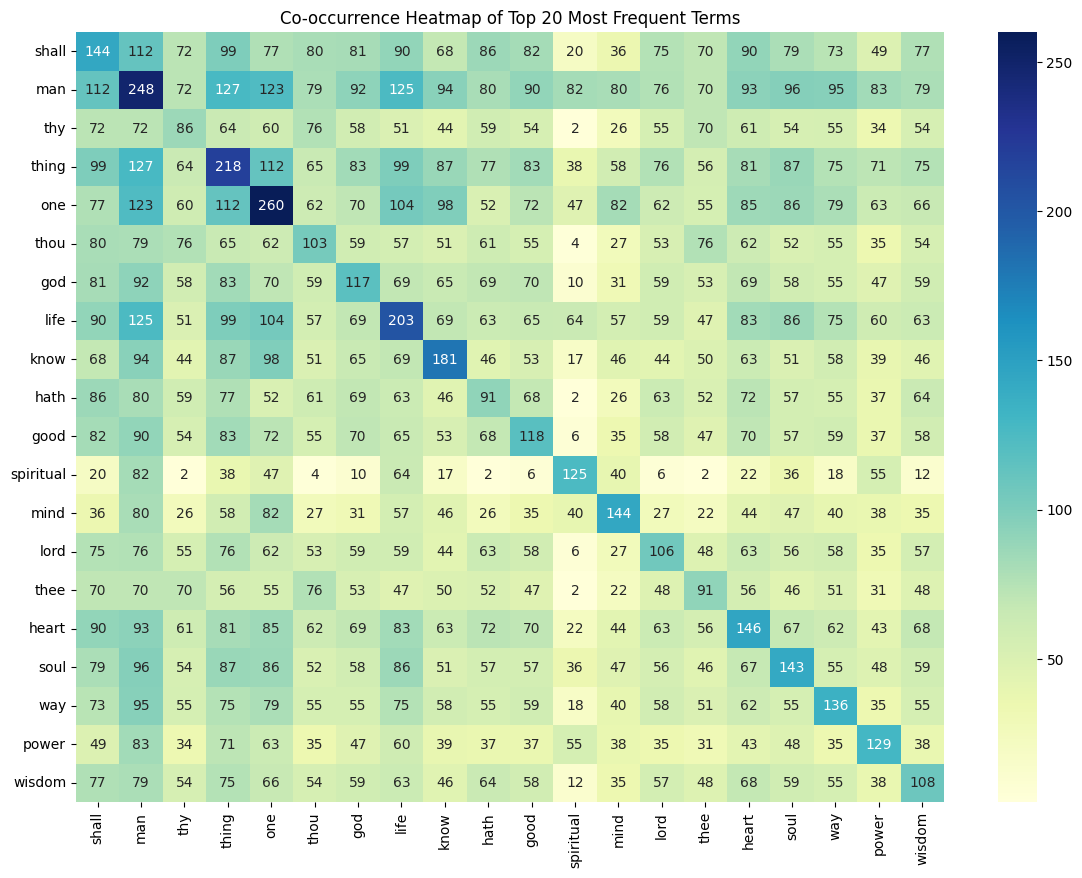

In [12]:
# Explore the most frequent common words across all the texts

# Sum each column to get total frequency, then select top 20 columns
top_20_cols = df.sum().sort_values(ascending=False).head(20).index

# Create a contingency table (co-occurrence matrix) for the top 20 columns
# We'll count how often each pair of words appears together in the same row (document)
contingency = pd.DataFrame(
    0, index=top_20_cols, columns=top_20_cols
)

for col1 in top_20_cols:
    for col2 in top_20_cols:
        # Count rows where both col1 and col2 are nonzero
        contingency.loc[col1, col2] = ((df[col1] > 0) & (df[col2] > 0)).sum()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Co-occurrence Heatmap of Top 20 Most Frequent Terms")
plt.show()

We find words that would make sense to be frequent in religious and classical philosophical books, like "man", "shall", "thy", "life", "death"... etc.

## Dimensionality reduction with PCA

In [13]:
# Standardize the data to be suitable for PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [14]:
# Looking for initial number of components that would not exceed the number of rows (minimum of rows and columns)
num_components = min(len(df), len(df.columns))
# Initiate, fit and transform PCA
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])
print(num_components)

590


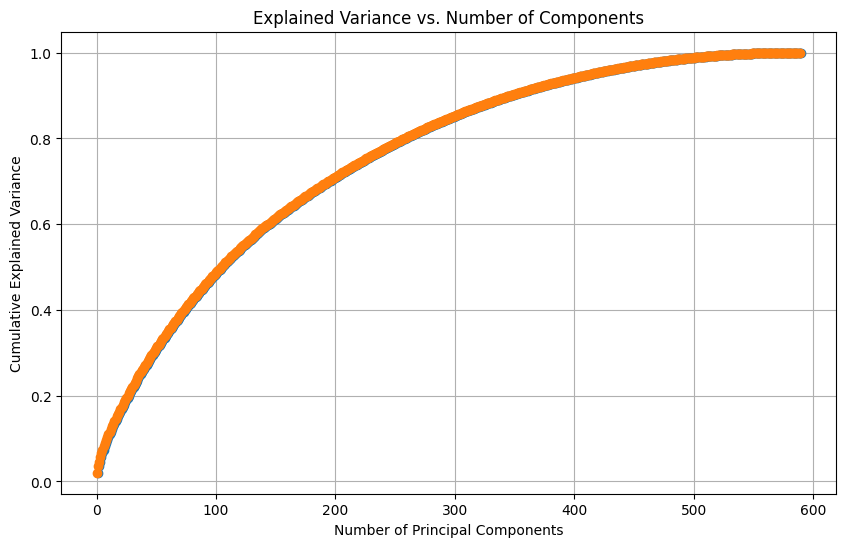

In [15]:
# Plot the explained variance ratio of the initial number of components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

The number of components can be further reduced to include only components that have explained variance above 95%.

In [16]:
# Retain the number of components that explain at least 95% of the variance
optimal_components = np.argmax(cumulative_variance >= 0.95)
# Fit PCA again with the optimal number of components
pca_reduced = PCA(n_components=optimal_components)
df_pca_reduced = pca_reduced.fit_transform(df_scaled)
# Pring the optimal number of components
print(f"Optimal number of components to retain 95% variance: {optimal_components}")

Optimal number of components to retain 95% variance: 414


## Finding the optimal number of clusters

### Method 1: K-means with silhouette scores and elbow method

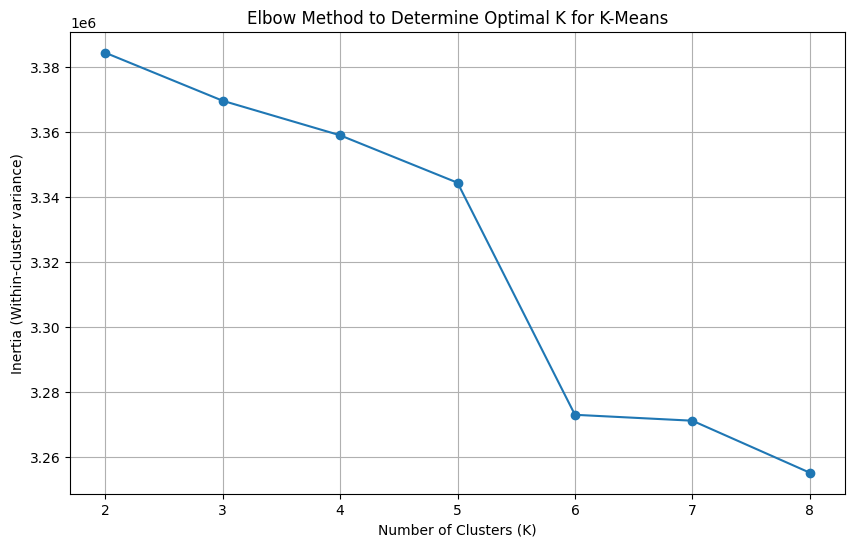

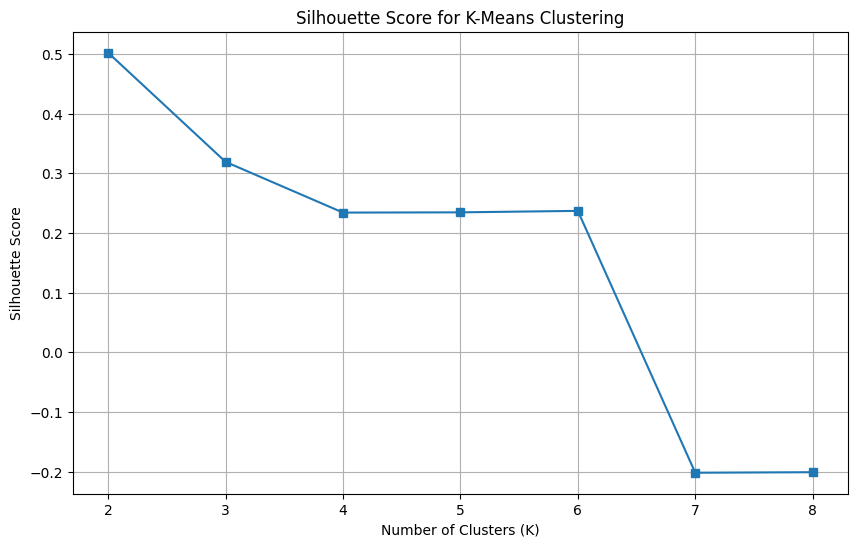

In [17]:
# Initiate possible number of clusters between 2 and the number of books (8)
n_clusters_range = range(2, 9)

# Initiate empty lists to store inertia and silhouette scores
inertia = []
kmeans_silhouette_scores = []

# Fit KMeans for each possible number of clusters and append inertia and silhouette scores to the lists
for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=888)
    kmeans.fit(df_pca_reduced)
    
    inertia.append(kmeans.inertia_)
    kmeans_silhouette_scores.append(silhouette_score(df_pca_reduced, kmeans.labels_))

# Plot the elbow method to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal K for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster variance)')
plt.grid()
plt.show()

# Plot the silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, kmeans_silhouette_scores, marker='s')
plt.title('Silhouette Score for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

We see that the plots have unusual looks. The elbow method is not detecting a clear optimal number of clusters. Silhoutte score plot however is pointing to a number of clusters of two, which has the highest score.

### Method 2: Gaussian Mixture Model (GMM) with Bayesian Information Criterion (BIC) scores and silhoutte scores 

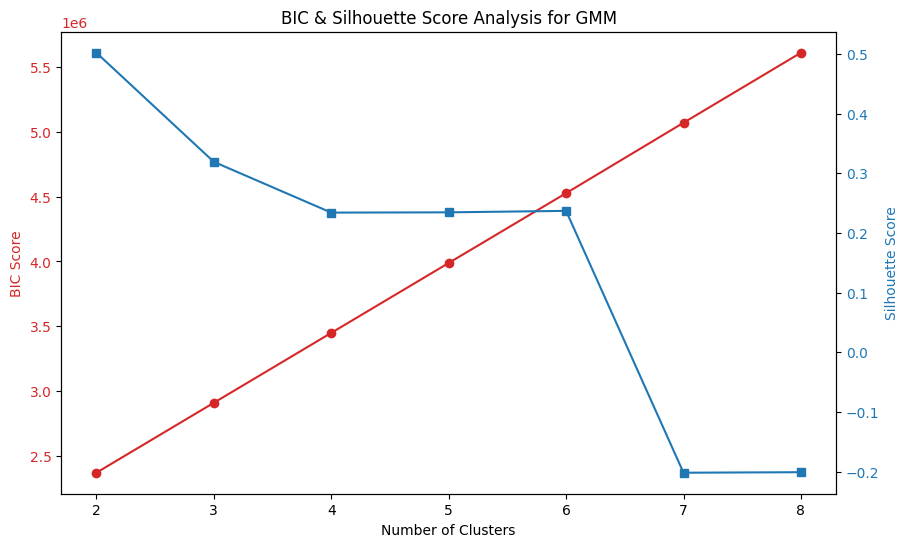

In [18]:
# Initiate empty lists to store BIC and silhouette scores for GMM
bic_scores = []
gmm_silhoutte_scores = []

# Use the same range of clusters identified above to initiate GMM
for n_components in n_clusters_range:
    gmm = GaussianMixture(n_components=n_components, random_state=888)
    gmm.fit(df_pca_reduced)
    # Append BIC and silhouette scores to the lists
    bic_scores.append(gmm.bic(df_pca_reduced))
    gmm_silhoutte_scores.append(silhouette_score(df_pca_reduced, gmm.predict(df_pca_reduced)))

# Plot BIC and silhouette scores for GMM in one graph
fig, ax1 = plt.subplots(figsize=(10, 6))
# The line for BIC scores
color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('BIC Score', color=color)
ax1.plot(n_clusters_range, bic_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
# The line for silhouette scores
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)  # we already handled the x-label with ax1
ax2.plot(n_clusters_range, gmm_silhoutte_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# Add a title and show the plot
plt.title('BIC & Silhouette Score Analysis for GMM')
plt.show()

Again, an unusual graph. But it clearly points out two clusters as the optimal number of clusters, which has the highest silhoutte score and the lowest BIC score.

### Method 3: Hierarchical clustering with a dendogram

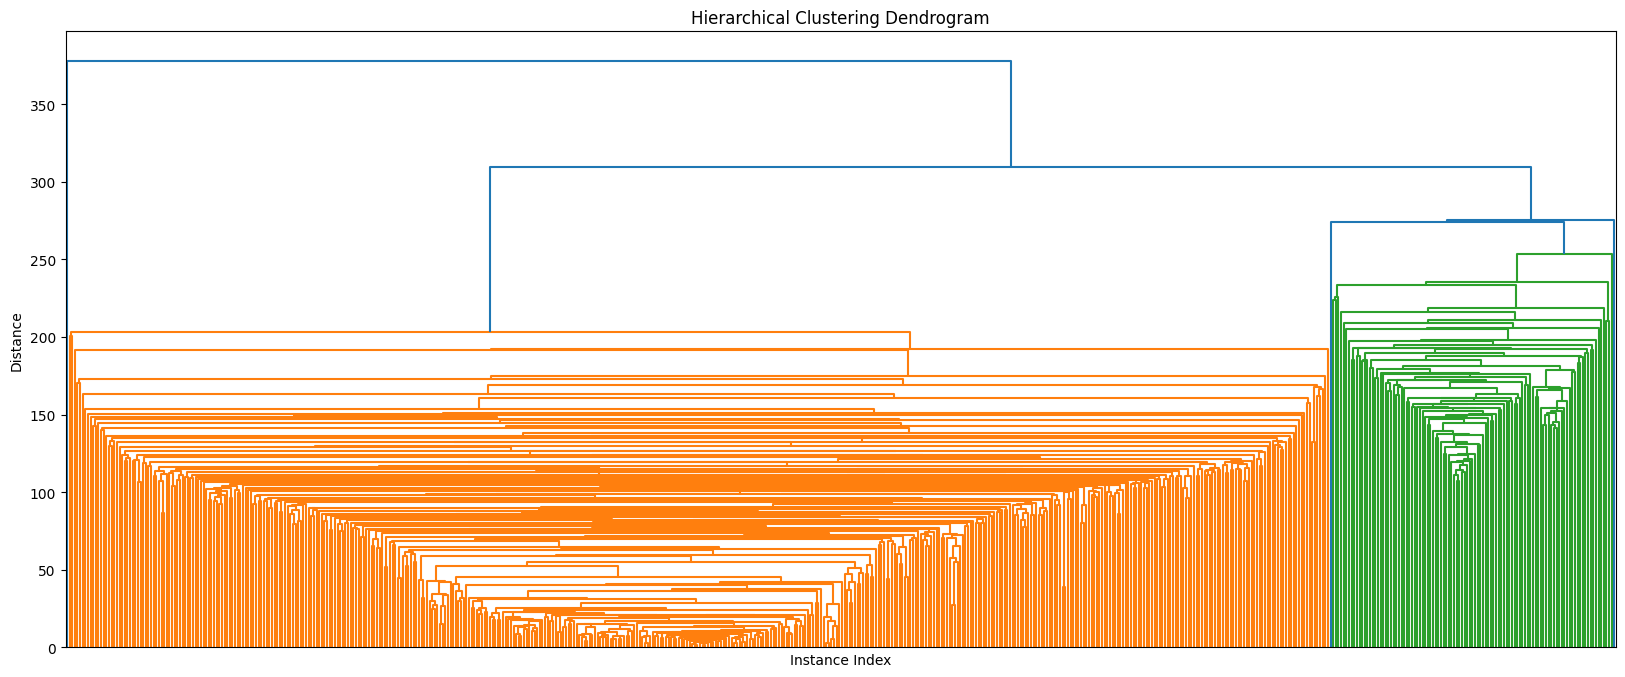

In [19]:
# Initate the linkage for hierarchical clustering
linkage_matrix = linkage(df_pca_reduced, method='ward', optimal_ordering=True)
# Plot the dendrogram
plt.figure(figsize=(20, 8))
dendrogram(linkage_matrix, leaf_font_size=8, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Instance Index")
plt.ylabel("Distance")
plt.show()


In the dendrogram, it is clear that there are two major clusters, represented by the green and the orange colours. It is also clear that the two clusters have different sizes, yet very distinct from each other. Some clades are separated, represented by the long isolated blue lines, representing outliers or non-typical observations (chapters).

### Which method to choose?

- K-means: The most familiar choice, but it is giving confusing answer regarding the number of clusters. That is very highly likely because k-means is best suitable for clear, well-separated clusters, which is unlikely to be the case of religious and philosophical books, as they are highly likely to have some thematic overlaps.
- GMM: Better suitable for overlapping boundaries and detects 2 as the best number of clusters.
- Hierarchical clustering: Gives a clear representation of how each chapter relate to the other chapters within the same book and other book, as well as to their main two sub-groups (clusters).

Therefore, with affirmation from GMM, hierarchical clustering can be preferered for the clear visual of the dendrogram. Also, GMM and hierarchical clustering better suits the thematic overlapping that is expected in religious and philosophical texts.

## Assigning clusters according to hierarchical clustering and exploring thematic differences and similarities

In [22]:
# Extract the cluster labels
cluster_labels = fcluster(linkage_matrix, t=280, criterion='distance')
# Add the cluster labels to the original dataframe
df['Cluster'] = cluster_labels
df['Cluster'].value_counts()

Cluster
1    480
2    109
3      1
Name: count, dtype: int64

We see that assigning clusters based on hierarchical clustering results in two clusters with one outlier. This outlier will be manually merged with the cluster that has similar books.

In [23]:
# Check the top 20 words in each cluster to better understand the clusters
for cluster in sorted(df['Cluster'].unique()):
    print(f"Cluster {cluster}:")
    cluster_df = df[df['Cluster'] == cluster]
    top_words = cluster_df.drop(columns=['Cluster']).sum().sort_values(ascending=False).head(20)
    print(top_words)
    print("\n")

Cluster 1:
one              343
man              334
spiritual        301
know             250
life             232
mind             210
power            201
thing            200
consciousness    182
self             176
come             165
see              153
say              152
right            142
great            135
knowledge        134
form             134
soul             127
may              124
call             123
dtype: int64


Cluster 2:
shall     1054
thy        607
man        513
thou       389
thing      341
god        320
hath       318
lord       263
good       261
thee       256
wisdom     202
heart      202
upon       186
word       176
wicked     166
soul       165
work       164
men        158
wise       157
give       154
dtype: int64


Cluster 3:
discern        47
remain         43
mind           43
body           40
focus          39
feel           36
monk           29
breathe        20
quality        18
mental         17
way            15
externally     15
f

From the top frequent words, it is not clear to which cluster should the outlier chapter in the third cluster belong. This will be determined based on the names of the books.

In [24]:
# Add back the labels to the original dataframe
df_complete = df.merge(labels, how='left', left_index=True, right_index=True)
# Check the merged dataframe
df_complete.iloc[:, -3:].head()

,Cluster,chapters,books
0,1,Buddhism_Ch1,Buddhism
1,1,Buddhism_Ch2,Buddhism
2,1,Buddhism_Ch3,Buddhism
3,1,Buddhism_Ch4,Buddhism
4,1,Buddhism_Ch5,Buddhism


In [25]:
# Check the contingent frequency table of clusters and books
# This will show how many chapters from each book are in each cluster
pd.crosstab(df_complete['Cluster'], df_complete['books']).T

Cluster,1,2,3
books,,,
BookOfEccleasiasticus,1,49,0
BookOfEcclesiastes,2,10,0
BookOfProverb,2,29,0
BookOfWisdom,0,19,0
Buddhism,44,1,1
TaoTeChing,81,0,0
Upanishad,162,0,0
YogaSutra,188,1,0


From the contingency table above, we can see two clear clusters.

Cluster 1 is dominantly Asian philosophical books, while Cluster 2 are almost all biblical literature books. The outlier chapter in Cluster 3 belongs to Buddhism (Buddha Sutras) and therefore will be merged with the Asian philosophical books cluster, resulting in only two clusters, that will be renamed accordingly.

In [27]:
# Rename the clusters to more meaningful names and manually merge Cluster 3 to the Asian Philosophy cluster
df_complete['Cluster'] = df_complete['Cluster'].astype(str)
df_complete['Cluster'] = (
                        df_complete['Cluster']\
                        .str.replace('1', 'Asian Philosophy', regex=False)\
                        .str.replace('2', 'Biblical Literature', regex=False)\
                        .str.replace('3', 'Asian Philosophy', regex=False)
)

pd.crosstab(df_complete['Cluster'], df_complete['books']).T

Cluster,Asian Philosophy,Biblical Literature
books,,
BookOfEccleasiasticus,1,49
BookOfEcclesiastes,2,10
BookOfProverb,2,29
BookOfWisdom,0,19
Buddhism,45,1
TaoTeChing,81,0
Upanishad,162,0
YogaSutra,188,1


In [29]:
# Check the total number of chapters in each cluster, ratio between the two clusters, and purity of each cluster

# Number of chapters in each cluster
asian_cluster_cnt = len(df_complete[df_complete['Cluster'] == 'Asian Philosophy'])
biblical_cluster_cnt = len(df_complete[df_complete['Cluster'] == 'Biblical Literature'])

# Purity of each cluster
asian_cluster_purity = len(df_complete[(df_complete['Cluster'] == 'Asian Philosophy') & \
                            (~df_complete['books'].str.contains('Book'))]) / asian_cluster_cnt * 100

biblical_cluster_purity = len(df_complete[(df_complete['Cluster'] == 'Biblical Literature') & \
                            (df_complete['books'].str.contains('Book'))]) / biblical_cluster_cnt * 100

print(f"Number of chapters in Asian Philosophy cluster: {asian_cluster_cnt}")
print(f"Number of chapters in Biblical Literature cluster: {biblical_cluster_cnt}")
print(f"Ratio between the two clusters: {asian_cluster_cnt / biblical_cluster_cnt:.2f}")
print(f"Purity of Asian Philosophy cluster: {asian_cluster_purity:.1f}%")
print(f"Purity of Biblical Literature cluster: {biblical_cluster_purity:.1f}%")


Number of chapters in Asian Philosophy cluster: 481
Number of chapters in Biblical Literature cluster: 109
Ratio between the two clusters: 4.41
Purity of Asian Philosophy cluster: 99.0%
Purity of Biblical Literature cluster: 98.2%


We notice that the Asian Philosophy cluster is 4.4 times larger than the biblical literature one. This will be important to keep in mind while checking top common words between the two clusters.

### The most common words in each cluster (Thematic differences)

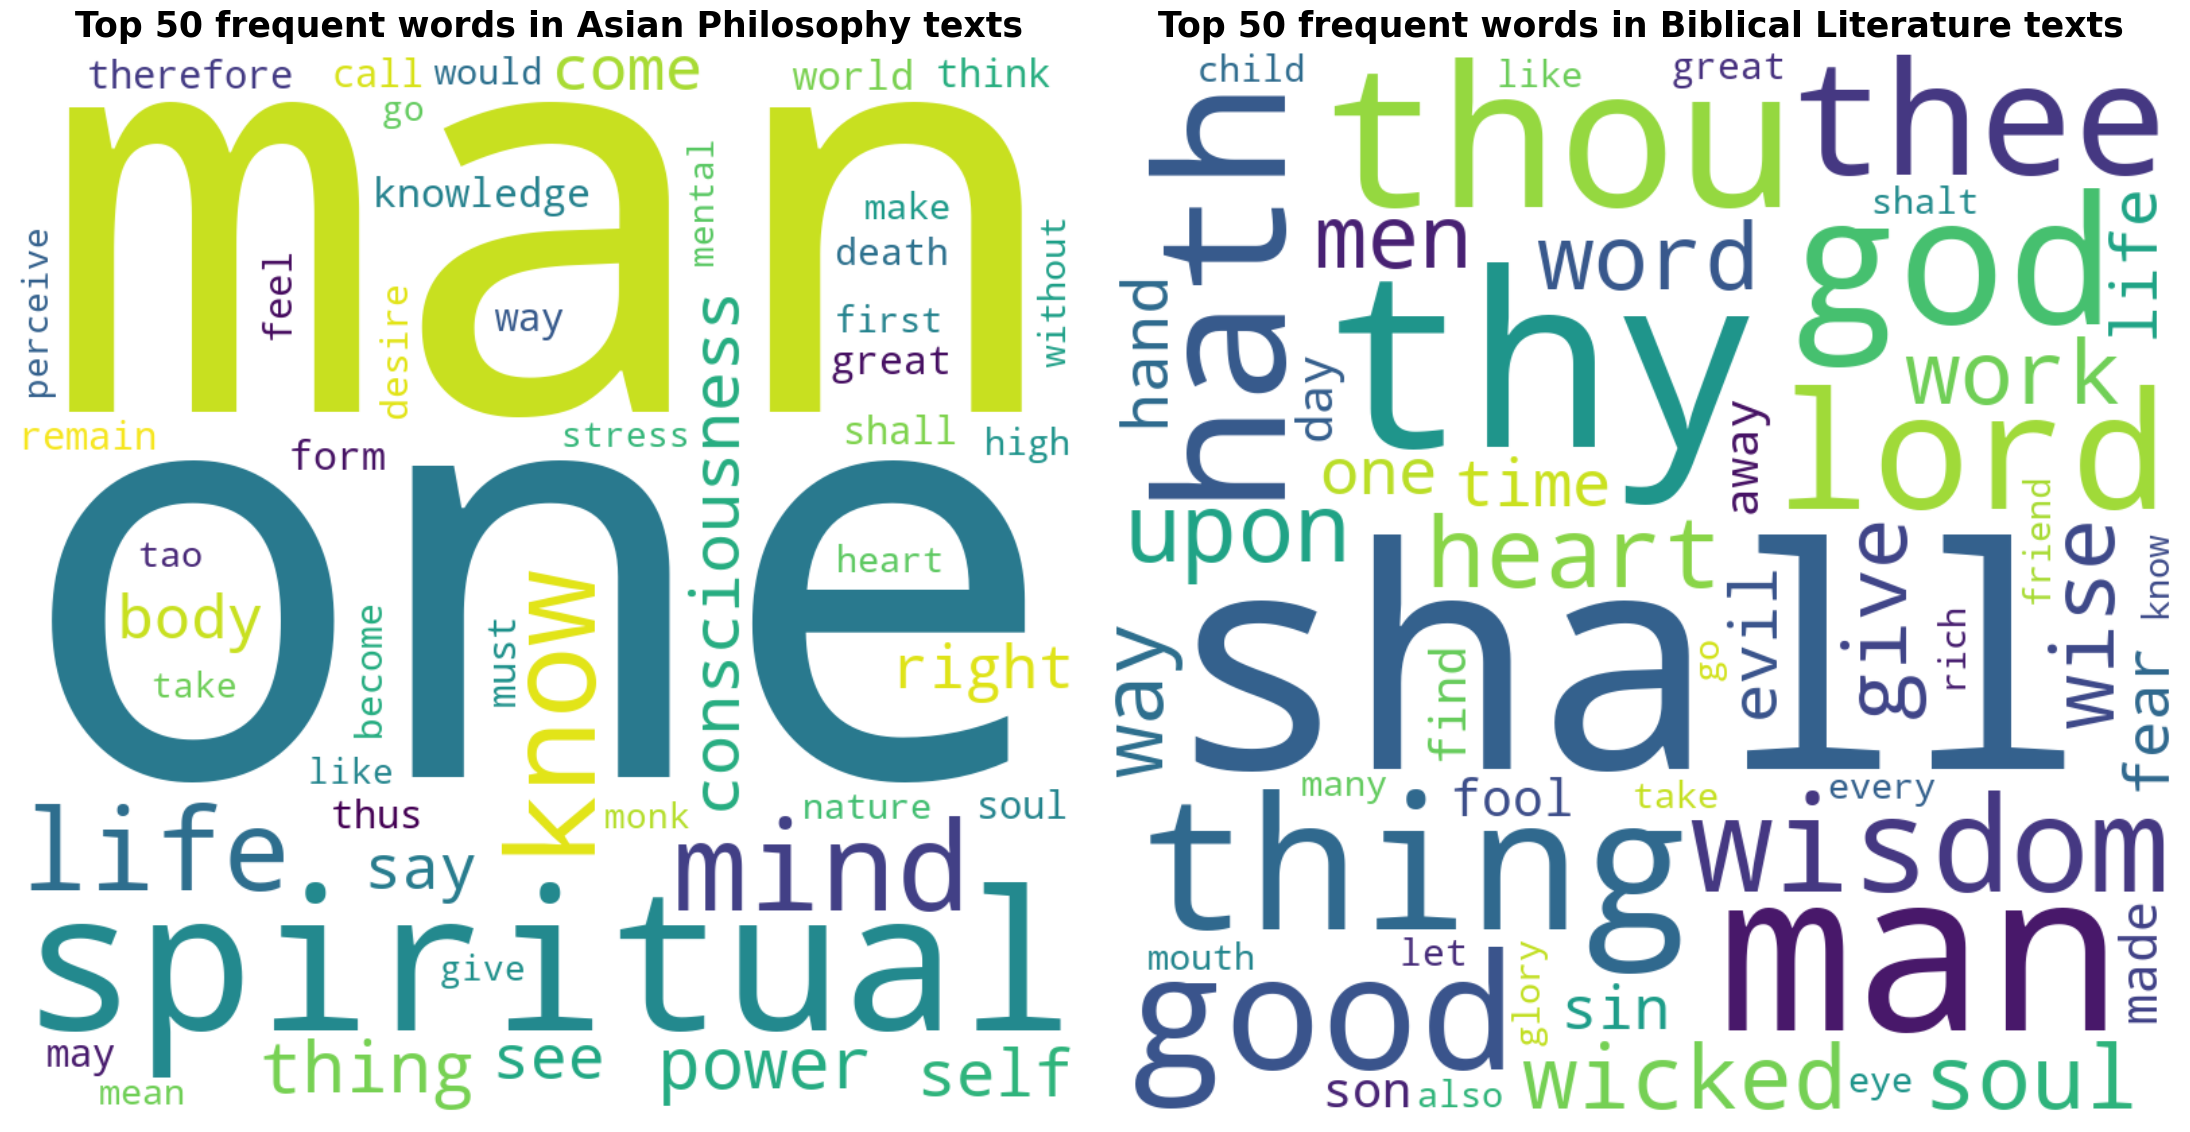

In [32]:
# Check and plot in a word cloud the top most frequent words in each cluster

clusters = df_complete['Cluster'].unique()

fig, axes = plt.subplots(1, 2, figsize=(22, 12))

for i, cluster in enumerate(clusters):
    # Iterate through the clusters and create a word cloud for each
    cluster_df = df_complete[df_complete['Cluster'] == cluster]
    # Drop the columns that are not words, sum the frequencies and retain the top 50 words
    word_freq = cluster_df.drop(columns=['Cluster', 'books', 'chapters']).sum().sort_values(ascending=False).head(50)
    # Plot the word cloud
    wc = WordCloud(width=800, height=800, background_color='white', margin=15).generate_from_frequencies(word_freq)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Top 50 frequent words in {cluster} texts', fontsize=25, fontweight='bold')

plt.tight_layout()
plt.show()

The word cloud isually confirms the thematic split between Biblical Wisdom Literature and Eastern Philosophical Texts, reinforcing the rationale behind the clustering.

**Key Observations from Each Cluster**

**Asian Philosophy (Cluster 1)**
- Words like "mind," "life," "spiritual," "consciousness," "soul," "nature," "tao," "death," "perception," "self."
- These words reflect themes of meditation, self-awareness, balance, and the nature of existence.
- The frequent appearance of "one," "true," "must," "way," "thus," "remains" suggests an emphasis on inner journey, interconnectedness, and understanding reality beyond duality.
- This Cluster focuses on self-realization, spiritual philosophy, and inner harmony rather than moral law or structured ethical teachings.


**Biblical Wisdom Literature (Cluster 2)**
- Dominated by words like "God," "thou," "hath," "Lord," "shall," "thee," "wisdom," "fear," "justice," "wicked," "wise," "glory," "poor."
- These words align with structured moral teachings, emphasizing divine authority, justice, righteousness, and fear of God.
- The presence of "fool," "give," "mouth" reflects practical guidance on moral behavior, contrasting wisdom and folly.
- This confirms that Cluster 1 is deeply rooted in ethical instruction, practical morality, and a divinely inspired concept of wisdom.

The clustering and word cloud reveal two fundamentally different approaches to wisdom: 

1️⃣ Asian Philosophy (self-discovery, meditative, consciousness-focused)

2️⃣ Biblical Wisdom (structured, moral, divine-driven)

Both clusters aim for wisdom, but one through divine commandments, the other through inner reflection.



### The most common mutual words (Thematic similarities)

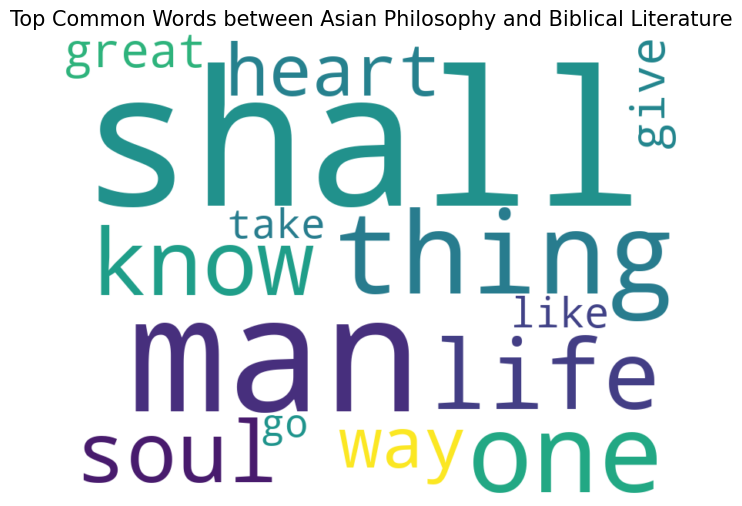

In [35]:
# Check and plot in a word cloud the top most frequent words that are mutuall common between the clusters

# To eliminate the effect of varying cluster sizes, we normalize frequencies for each cluster first
# Create a separate dataframe for each cluster containing only the words
asian_df = df_complete[df_complete['Cluster'] == 'Asian Philosophy'].drop(columns=['Cluster', 'books', 'chapters'])
biblical_df = df_complete[df_complete['Cluster'] == 'Biblical Literature'].drop(columns=['Cluster', 'books', 'chapters'])
# Normalize the frequencies for each cluster
asian_freq = asian_df.sum() / asian_df.values.sum()
biblical_freq = biblical_df.sum() / biblical_df.values.sum()

# Get the top 50 words for each cluster (by normalized frequency)
asian_words = set(asian_freq.sort_values(ascending=False).head(50).index)
biblical_words = set(biblical_freq.sort_values(ascending=False).head(50).index)

# Find common words in both clusters' top 50
common_words = list(asian_words & biblical_words)

# Get the top 20 most frequent among the common words (using average normalized frequency)
avg_freq = (asian_freq[common_words] + biblical_freq[common_words]) / 2
top_20_common = avg_freq.sort_values(ascending=False).head(20)


# Generate and plot the word cloud
wc = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(top_20_common)
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Top Common Words between Asian Philosophy and Biblical Literature", fontsize=15)
plt.show()


The word cloud suggests that both Asian Philosophy and Biblical Wisdom Literature share foundational themes related to human existence, morality, and spiritual insight.

**Key Observations from the Word Cloud**

1️⃣ **Common Themes Across Both Traditions**
- Words like "life," "soul," "heart," "know," "way," "great," "give," "take," "man," "one" indicate shared concepts of wisdom, morality, and the nature of existence.
- Both traditions focus on understanding human behavior and the pursuit of enlightenment or righteousness.

2️⃣ **Concepts of Choice & Action**
- Words like "shall," "give," "take," "go" imply an emphasis on decision-making and moral action.
- Biblical wisdom literature often associates action with divine justice, while Eastern philosophy views action as part of karma or the natural flow (Tao).

3️⃣ **Existential & Spiritual Themes**
- Words like "soul," "heart," "one," "way" suggest reflections on identity, consciousness, and unity.
- Biblical wisdom texts frame the soul in relation to God, while Asian philosophy discusses the mind and its harmony with existence.


### Appendix - Cross-border chapters: Chapters that belong to one cluster but sound like the other

In [36]:
# Get biblical literature chapters that sound like asian philosophy books
bibilical_ch_asian_cluster = df_complete[['chapters']][(df_complete['Cluster'] == 'Asian Philosophy') & \
                            (df_complete['books'].str.contains('Book'))].copy()
# Get asian philosophy chapters that sound like biblical literature books
asian_ch_biblical_cluster = df_complete[['chapters']][(df_complete['Cluster'] == 'Biblical Literature') & \
                            (~df_complete['books'].str.contains('Book'))].copy()
# Check the names of the cross-border chapters
print(f'Biblical Literature chapters that sound like asian philosophy books: \n {bibilical_ch_asian_cluster}')
print(f'Asian Philosophy chapters that sound like Biblical Literature: \n {asian_ch_biblical_cluster}')


Biblical Literature chapters that sound like asian philosophy books: 
                        chapters
479           BookOfProverb_Ch2
486           BookOfProverb_Ch9
514      BookOfEcclesiastes_Ch6
519     BookOfEcclesiastes_Ch11
535  BookOfEccleasiasticus_Ch15
Asian Philosophy chapters that sound like Biblical Literature: 
            chapters
41    Buddhism_Ch42
340  YogaSutra_Ch52


#### Excerpts from Biblical Literature chapters that sound like Asian philosophy books

1- **Book Of Proverbs, Ch2:** 2:1. My son, if thou wilt receive my words, and wilt hide my commandments with thee,  2:2. That thy ear may hearken to wisdom: incline thy heart to know prudence.  2:3. For if thou shalt call for wisdom, and incline thy heart to prudence:  2:4. If thou shalt seek her as money, and shalt dig for her as for a treasure:  2:5. Then shalt thou understand the fear of the Lord, and shalt find the knowledge of God:  2:6. Because the Lord giveth wisdom: and out of his mouth cometh prudence and knowledge.  2:7. He wilt keep the salvation of the righteous, and protect them that walk in simplicity,  2:8. Keeping the paths of justice, and guarding the ways of saints.  2:9. Then shalt thou understand justice, and judgment, and equity, and every good path.  2:10. If wisdom shall enter into thy heart, and knowledge please thy soul.

2- **Book Of Proverbs, Ch9:** 9:1. Wisdom hath built herself a house, she hath hewn her out seven pillars.  9:2. She hath slain her victims, mingled her wine, and set forth her table.  9:3. She hath sent her maids to invite to the tower, and to the walls of the city:  9:4. Whosoever is a little one, let him come to me.  And to the unwise she said:  9:5. Come, eat my bread, and drink the wine which I have mingled for you.  9:6. Forsake childishness, and live, and walk by the ways of prudence.

3- **Book Of Ecclesiastes, Ch6:** 6:1. There is also another evil, which I have seen under the sun, and that frequent among men:  6:2. A man to whom God hath given riches, and substance, and honour, and his soul wanteth nothing of all that he desireth: yet God doth not give him power to eat thereof, but a stranger shall eat it up. This is vanity and a great misery.  6:3. If a man beget a hundred children, and live many years, and attain to a great age, and his soul make no use of the goods of his substance, and he be without burial: of this man I pronounce, that the untimely born is better than he.  6:4. For he came in vain, and goeth to darkness, and his name shall be wholly forgotten.  6:5. He hath not seen the sun, nor known the distance of good and evil:  6:6. Although he lived two thousand years, and hath not enjoyed good things: do not all make haste to one place?  6:7. All the labour of man is for his mouth, but his soul shall not be filled.

4- **Book Of Ecclesiastes, Ch11:** 11:7. The light is sweet, and it is delightful for the eyes to see the sun.  11:8. If a man live many years, and have rejoiced in them all, he must remember the darksome time, and the many days: which when they shall come, the things past shall be accused of vanity.  11:9. Rejoice therefore, O young man, in thy youth, and let thy heart be in that which is good in the days of thy youth, and walk in the ways of thy heart, and in the sight of thy eyes: and know that for all these God will bring thee into judgment.  11:10. Remove anger from thy heart, and put away evil from thy flesh. For youth and pleasure are vain.

5- **Book Of Eccleasiasticus, Ch15:** 15:1. He that feareth God, will do good: and he that possesseth justice, shall lay hold on her,  15:2. And she will meet him as an honourable mother, and will receive him as a wife married of a virgin.  15:3. With the bread of life and understanding, she shall feed him, and give him the water of wholesome wisdom to drink: and she shall be made strong in him, and he shall not be moved.  15:4. And she shall hold him fast, and he shall not be confounded: and she shall exalt him among his neighbours.  15:5. And in the midst of the church she shall open his mouth, and shall fill him with the spirit of wisdom and understanding, and shall clothe him with a robe of glory.  15:6. She shall heap upon him a treasure of joy and gladness, and shall cause him to inherit an everlasting name.

#### Excerpts from Asian Philosophy chapters that sound like Biblical Literature

1- **Buddhism, Ch42:** "Now what, monks, is the five-factored noble right concentration? There is the case where a monk — quite withdrawn from sensuality, withdrawn from unskillful (mental) qualities — enters & remains in the first jhana: rapture & pleasure born from withdrawal, accompanied by directed thought & evaluation. He permeates & pervades, suffuses & fills this very body with the rapture & pleasure born from withdrawal. There is nothing of his entire body unpervaded by rapture & pleasure born from withdrawal."Just as if a skilled bathman or bathman's apprentice would pour bath powder into a brass basin and knead it together, sprinkling it again & again with water, so that his ball of bath powder — saturated, moisture-laden, permeated within & without — would nevertheless not drip; even so, monks, the monk permeates... this very body with the rapture & pleasure born of withdrawal.

2- **YogaSutra, Ch52:** Let us try to translate this into terms of the psychical and spiritual man. The darkness of unwisdom is, primarily, the self-absorption of the psychical man, his complete preoccupation with his own hopes and fears, plans and purposes, sensations and desires; so that he fails to see, or refuses to see, that there is a spiritual man; and so doggedly resists all efforts of the spiritual man to cast off his psychic tyrant and set himself free. This is the real darkness; and all those who deny the immortality of the soul, or deny the soul's existence, and so lay out their lives wholly for the psychical, mortal man and his ambitions, are under this power of darkness.

## Conclusion: Key Findings and Insights

This analysis of Asian religious texts and Biblical literature reveals fascinating patterns in religious and philosophical discourse through text clustering. Here are the key findings:

### 1. Optimal Clustering
- Despite having 8 different source texts, the analysis consistently identified 2 distinct clusters across multiple clustering methods (K-means, GMM, and Hierarchical Clustering)
- The final clusters showed high purity rates:
  - Asian Philosophy cluster: 99% purity
  - Biblical Literature cluster: 98% purity
- The Asian Philosophy cluster is 4.4 times larger than the Biblical Literature cluster

### 2. Thematic Distinctions

**Asian Philosophy Cluster**
- Focuses on inner journey, self-realization, and consciousness
- Key themes: mind, spiritual awareness, nature, perception
- Emphasizes personal exploration and understanding of existence
- More meditative and introspective approach

**Biblical Literature Cluster**
- Centers on divine authority, moral law, and structured teachings
- Key themes: God, Lord, wisdom, justice, righteousness
- Emphasizes practical moral guidance and fear of God
- More prescriptive and authority-based approach

### 3. Shared Universal Themes
Despite distinct approaches, both traditions share fundamental concerns:
- Human existence and mortality
- The nature of wisdom and knowledge
- The importance of moral action
- The concept of soul/spirit
- The path to enlightenment/righteousness

### 4. Cross-Border Cases
The analysis identified interesting cases where texts from one tradition showed thematic similarities with the other:
- 5 Biblical chapters (mainly from Proverbs, Ecclesiastes, and Ecclesiasticus) showed similarities with Asian philosophical texts
- 2 Asian texts (from Buddhism and YogaSutra) showed similarities with Biblical literature

These findings suggest that while Eastern and Western religious/philosophical traditions have distinct approaches to wisdom and spirituality, they share fundamental human concerns and occasionally bridge their characteristic differences in addressing these concerns.

This clustering analysis provides quantitative support for comparative religious studies and demonstrates how modern data science techniques can offer new insights into ancient spiritual texts.